In [1]:
import pandas as pd
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from spacy import displacy

import seaborn as sns
import string

import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud,STOPWORDS

from PIL import Image
import numpy as np

In [7]:
nlp = spacy.load('en_core_web_sm')

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [5]:
!pip install spacy

## Text Classification

In [8]:
data = pd.read_csv('Product_reviews.csv')
data.columns

Index(['title', 'rating', 'body', 'date'], dtype='object')

In [9]:
df = data.copy().drop(columns=['date', 'title'])
df.rename(columns={'body':'review'},inplace=True)
print(len(df))
df.head()

557


,rating,review
0,5.0,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...
1,1.0,"Earlier I gave a positive review, but after us..."
2,5.0,Inalsa Air Fryer...this is awesome product ......
3,2.0,I bought this in the prime day sale on 15th Ju...
4,1.0,Product has manufacturing defect as the right ...


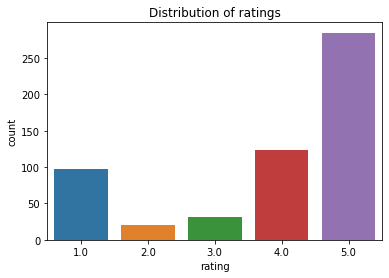

In [10]:
sns.countplot(data= df, x='rating')
plt.title('Distribution of ratings');

In [11]:
def labeling(rating):
    if rating >=3:
        return 'pos'
    else:
        return 'neg'

In [12]:
df['rating_label'] = df['rating'].apply(labeling)

<strong>Limitations:</strong><br>
    Customers who have rated product as satisfactory, however reviewed it critically are misclassified<br>
    Customers who have rated the product as 1/2 stars and reviewed it positively (mostly those unaware of the working of rating scale) <br>
    Element of arbitrariness

In [13]:
sid = SentimentIntensityAnalyzer()

df['compound_score'] = df['review'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['compound'])
# = df['scores']
df['vader_label'] = df['compound_score'].apply(lambda c: 'pos' if c >= 0 else 'neg')
df.head()

,rating,review,rating_label,compound_score,vader_label
0,5.0,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...,pos,0.9813,pos
1,1.0,"Earlier I gave a positive review, but after us...",neg,0.7941,pos
2,5.0,Inalsa Air Fryer...this is awesome product ......,pos,0.6249,pos
3,2.0,I bought this in the prime day sale on 15th Ju...,neg,-0.6808,neg
4,1.0,Product has manufacturing defect as the right ...,neg,-0.8519,neg


In [14]:
temp = df[df['vader_label']!=df['rating_label']]
print(f'Number of label mismatches: {len(temp)}')

Number of label mismatches: 56


In [11]:
temp.head(7)

,rating,review,rating_label,compound_score,vader_label
1,1.0,"Earlier I gave a positive review, but after us...",neg,0.7941,pos
11,2.0,I brought this after comparing other fryers di...,neg,0.5859,pos
15,1.0,Helo I have purchased hairdryer of Inalsa dry ...,neg,0.4497,pos
19,4.0,I have not seen other compeny Air fryer so I c...,pos,-0.2617,neg
33,4.0,Original package had a hole on side and the pr...,pos,-0.1884,neg
34,1.0,Air frier is just delivered..First of all pack...,neg,0.0000,pos
39,1.0,Received defective product. Not able to return...,neg,0.6919,pos


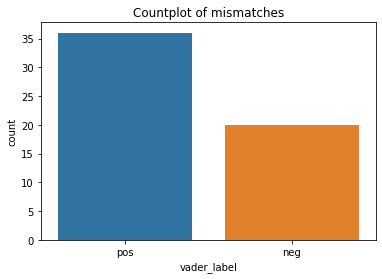

In [15]:
sns.countplot(data=temp, x= 'vader_label')
plt.title('Countplot of mismatches');

In [16]:
sns.kdeplot(x=temp[temp['vader_label']=='pos']['compound_score'])
plt.title('Compound score distribution of mismatches classified as positive by VADER \n');

TypeError: kdeplot() missing 1 required positional argument: 'data'

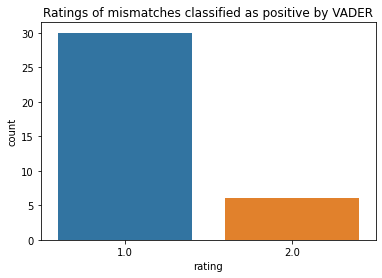

In [17]:
sns.countplot(x=temp[temp['vader_label']=='pos']['rating'])
plt.title('Ratings of mismatches classified as positive by VADER');

In [18]:
pos = temp[temp['vader_label']=='pos']
for i in range(len(pos)):
    print(f'label: {pos.iloc[i,-3]} \t sentiment: {pos.iloc[i,-1]} \t rating: {pos.iloc[i,0]} \t compound score: {pos.iloc[i,-2]}')
    print(f'{pos.iloc[i,-4]} \n')

label: neg 	 sentiment: pos 	 rating: 1.0 	 compound score: 0.7941
Earlier I gave a positive review, but after using it for 1 month I would like to take back all the good things I said about the product.It is indeed cheap and the polish of the tray is coming off.What is more disappointing is their customer service, who doesn't have any credibility. They make fake commitments all the time whenever contacted.All the best if you've also purchased this item.Unfortunate Buyer,Sumit Saxena 

label: neg 	 sentiment: pos 	 rating: 2.0 	 compound score: 0.5859
I brought this after comparing other fryers displayed on Amazon. The reason I chose Inslsa, even though it was a bit costly than other models, is because it is shown as made in India among the queries section. This is MADE IN CHINA. I wish they are Frank enough to admit it, so that we can make a righteous choice. 

label: neg 	 sentiment: pos 	 rating: 1.0 	 compound score: 0.4497
Helo I have purchased hairdryer of Inalsa dry light on 24 

In [19]:
sns.kdeplot(x=temp[temp['vader_label']=='neg']['compound_score']);

TypeError: kdeplot() missing 1 required positional argument: 'data'

<AxesSubplot:xlabel='rating', ylabel='count'>

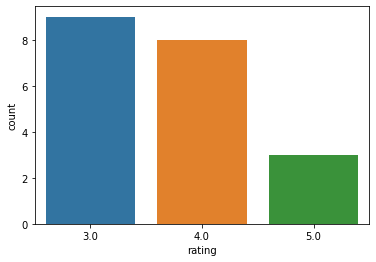

In [17]:
sns.countplot(x=temp[temp['vader_label']=='neg']['rating'])

In [20]:
neg = temp[temp['vader_label']=='neg']
for i in range(len(neg)):
    print(f'Rating label: {neg.iloc[i,-3]} \t Sentiment analysis label: {neg.iloc[i,-1]} \t rating: {neg.iloc[i,0]} \t compound score: {neg.iloc[i,-2]}')
    print(f'{neg.iloc[i,-4]} \n')

Rating label: pos 	 Sentiment analysis label: neg 	 rating: 4.0 	 compound score: -0.2617
I have not seen other compeny Air fryer so I can not compare ..About this product I make 🍟 but it's not that mark .. uneven cooking was seen , one side of 🥔 was cooked and other raw even though I shake them several times during cooking .. And same was with chicken wings ... 

Rating label: pos 	 Sentiment analysis label: neg 	 rating: 4.0 	 compound score: -0.1884
Original package had a hole on side and the product had broken handle. Received replacement which is working fine. One area of concern (reason for not giving 5 stars) is the handle to the basket is made of plastic and with no reinforcement the handle is very delicate. There is always a fear that it might break. If the handle had some kind of metal reinforcement in center then this fryer is best in its lot. 

Rating label: pos 	 Sentiment analysis label: neg 	 rating: 3.0 	 compound score: -0.4595
Bought one recently and have started maki

### Rated pos and vader neg
<ul>
    <li>Mostly customers who are otherwise satisfies but are critical in writing reviews (interesting people!)</li>
    <li>Few positive reviews which Vader wrongly classified as negative</li>
</ul>

### Rated neg and vader pos
<ul>
    <li>Mostly Vader wrongly classified negative reviews as positive</li>
    <li>Few Customers who are happy with the product but wrongly rated the product as worst (Amazon must work on this :P) </li>
</ul>

In [21]:
df['Final label'] = df['vader_label']
j = df.columns.get_loc('Final label')
for i in temp.index.values.tolist():
    df.iloc[i,j] = 'neg'
df.head()

,rating,review,rating_label,compound_score,vader_label,Final label
0,5.0,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...,pos,0.9813,pos,pos
1,1.0,"Earlier I gave a positive review, but after us...",neg,0.7941,pos,neg
2,5.0,Inalsa Air Fryer...this is awesome product ......,pos,0.6249,pos,pos
3,2.0,I bought this in the prime day sale on 15th Ju...,neg,-0.6808,neg,neg
4,1.0,Product has manufacturing defect as the right ...,neg,-0.8519,neg,neg


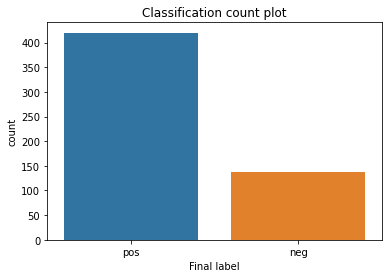

In [22]:
sns.countplot(data= df, x='Final label')
plt.title('Classification count plot');

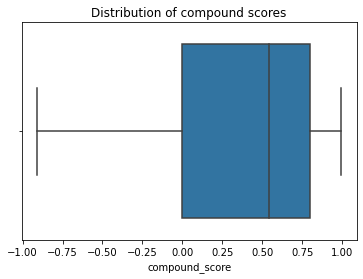

In [23]:
sns.boxplot(data=df,x='compound_score')
plt.title('Distribution of compound scores');
# 3 out 4 customers are happy with the product

In [24]:
df['Final label'].value_counts()/len(df)

pos    0.754039
neg    0.245961
Name: Final label, dtype: float64

In [25]:
print(accuracy_score(df['Final label'],df['vader_label']))
print(classification_report(df['Final label'],df['vader_label']))
print(confusion_matrix(df['Final label'],df['vader_label']))

0.9353680430879713
              precision    recall  f1-score   support

         neg       1.00      0.74      0.85       137
         pos       0.92      1.00      0.96       420

    accuracy                           0.94       557
   macro avg       0.96      0.87      0.90       557
weighted avg       0.94      0.94      0.93       557

[[101  36]
 [  0 420]]


Nevertheless vader has helped us filter misclassified reviews and improve our labels with some manual intervention.
More importantly it has provided us with a quantitative measure which can be leveraged for further classification.

In [27]:
sns.histplot(data=df,x='compound_score',bins=40);
# Most positive people are extremely happy with the product
# Comparatively some are extremely disappointed

AttributeError: module 'seaborn' has no attribute 'histplot'

In [25]:
# Segregate positive and negative reviews using final labels 
# Plot wordcloud for each 
# Draw inferences w.r.t challenges and features

In [28]:
def display_wordcloud(text,bg_color):
    #for word in []:
    #    STOPWORDS.add(word)
    path_to_font = 'C:/Users/priya/Downloads/bon_foyage/BonFoyageDemo.otf'
    #path_to_image = 'C:/Users/priya/OneDrive/Desktop/NLP_Project/IMG.png'
    # mask = np.array(Image.open(path_to_image))
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(stopwords=STOPWORDS, font_path=path_to_font,
               #mask=mask,
               background_color=bg_color,
               max_words=50, max_font_size=256,
               random_state=42, width=1000,
               height=1000).generate(text)
    plt.imshow(wordcloud,interpolation="bilinear") # display image
    plt.axis("off"); #No axis details

In [29]:
def clean_text(review):
    # remove numbers
    review = re.sub('[\d]+','',review) 
    # remove emoticon
    review = review.encode('ascii', 'ignore').decode('ascii') 
    # remove punctuation
    return "".join([x for x in review if x not in string.punctuation])    

In [30]:
df['cleaned review'] = df['review'].apply(lambda x:clean_text(x))
df.head()

,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review
0,5.0,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...,pos,0.9813,pos,pos,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...
1,1.0,"Earlier I gave a positive review, but after us...",neg,0.7941,pos,neg,Earlier I gave a positive review but after usi...
2,5.0,Inalsa Air Fryer...this is awesome product ......,pos,0.6249,pos,pos,Inalsa Air Fryerthis is awesome product Value ...
3,2.0,I bought this in the prime day sale on 15th Ju...,neg,-0.6808,neg,neg,I bought this in the prime day sale on th July...
4,1.0,Product has manufacturing defect as the right ...,neg,-0.8519,neg,neg,Product has manufacturing defect as the right ...


In [31]:
pos_reviews = df[df['Final label']=='pos']['cleaned review'].str.cat(sep=', ')
pos_reviews = ''.join(pos_reviews)
display_wordcloud(pos_reviews,'white') # '#f5faf8'

OSError: cannot open resource

<Figure size 720x720 with 0 Axes>

In [32]:
neg_reviews = df[df['Final label']=='neg']['cleaned review'].str.cat(sep=', ')
neg_reviews = ''.join(neg_reviews)
display_wordcloud(neg_reviews,'black') # '#fcf7f8'

OSError: cannot open resource

<Figure size 720x720 with 0 Axes>

## Emotion Mining

### Positive reviews

In [33]:
pos_reviews = df[df['Final label']=='pos']
pos_reviews.head()

,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review
0,5.0,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...,pos,0.9813,pos,pos,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...
2,5.0,Inalsa Air Fryer...this is awesome product ......,pos,0.6249,pos,pos,Inalsa Air Fryerthis is awesome product Value ...
5,4.0,My friend has this Inalsa air fryer since over...,pos,0.9809,pos,pos,My friend has this Inalsa air fryer since over...
6,5.0,Excellent way for cooking for veg and Non-veg ...,pos,0.9527,pos,pos,Excellent way for cooking for veg and Nonveg f...
8,4.0,Nice thing. We are fond of eating French fries...,pos,0.8689,pos,pos,Nice thing We are fond of eating French fries ...


In [34]:
# Emotion mining for positive reviews

In [ ]:
# Visualization

### Negative reviews

In [36]:
neg_reviews = df[df['Final label']=='pos']
neg_reviews.head()

,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review
0,5.0,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...,pos,0.9813,pos,pos,IT IS MORE THAN VALUE FOR MONEY HAPPY WITH THE...
2,5.0,Inalsa Air Fryer...this is awesome product ......,pos,0.6249,pos,pos,Inalsa Air Fryerthis is awesome product Value ...
5,4.0,My friend has this Inalsa air fryer since over...,pos,0.9809,pos,pos,My friend has this Inalsa air fryer since over...
6,5.0,Excellent way for cooking for veg and Non-veg ...,pos,0.9527,pos,pos,Excellent way for cooking for veg and Nonveg f...
8,4.0,Nice thing. We are fond of eating French fries...,pos,0.8689,pos,pos,Nice thing We are fond of eating French fries ...


In [ ]:
# Emotion mining for negative reviews 

In [ ]:
# Visualization

## Parts of Speech tagging

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
for token in doc[0:14]:
    print(token,end=' | ')
print('\n')
for token in doc[0:14]:
    print(token.pos_,end=' | ') 

In [103]:
# Created a dict of all pos tags from https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
# Go at bottom of notebook to run the hard coded dict tmp
# Run code to grab all pos tags

pos_tags = ['""', '#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'ADD', 'ADJ', 'ADP', 'ADV', 'AFX', 'AUX', 'BES', 'CC', 
            'CCONJ', 'CD', 'CONJ', 'DET', 'DT', 'EOL', 'EX', 'FW', 'GW', 'HVS', 'HYPH', 'IN', 'INTJ', 'JJ', 'JJR', 'JJS', 
            'LS', 'MD', 'NFP', 'NIL', 'NN', 'NNP', 'NNPS', 'NNS', 'NOUN', 'NUM', 'PART', 'PDT', 'POS', 'PRON', 'PROPN', 
            'PRP', 'PRP$', 'PUNCT', 'RB', 'RBR', 'RBS', 'RP', 'SCONJ', 'SP', 'SPACE', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG',
            'VBN', 'VBP', 'VBZ', 'VERB', 'WDT', 'WP', 'WP$', 'WRB', 'X', 'XX', '``']       

# Length was found as 75
len(pos_tags) 

# Created a list of random colors 
import random
random.seed(12)
color = []
while True:
    for i in range(len(pos_tags)):
        color.append("#%06x" % random.randint(0, 0xFFFFFF))
    if len(set(color))==len(pos_tags):
        break
color

# Ensured there are 75 unique colors
len(set(color))

75

In [104]:
def display_pos(text):
    doc = nlp(text)
    ents=[]
    for i in range(len(doc)):
        dicts = {}
        dicts['start'] = doc[i].idx
        dicts['end'] = doc[i].idx + len(doc[i])
        dicts['label'] = doc[i].pos_
        ents.append(dicts)
    ents

    ent_input = {
        "text": text,
        "ents": ents,
        "title": f'Parts of speech tagging'
    }

    colors = dict(zip(pos_tags, color))
    options = {"ents": pos_tags, "colors": colors}
    
    from spacy import displacy
    displacy.render(ent_input,style='ent',jupyter=True,manual=True,options=options)
    #displacy.serve(ent_input,style='ent',manual=True,options=options)

In [106]:
text = temp['review'][33]
print(text)
display_pos(text)

Original package had a hole on side and the product had broken handle. Received replacement which is working fine. One area of concern (reason for not giving 5 stars) is the handle to the basket is made of plastic and with no reinforcement the handle is very delicate. There is always a fear that it might break. If the handle had some kind of metal reinforcement in center then this fryer is best in its lot.


'broken handle' --> VERB + NOUN<br>
'very delicate' --> ADV + ADJ<br>

In [121]:
text = temp['review'][19]
print(text)
display_pos(text)

I have not seen other compeny Air fryer so I can not compare ..About this product I make 🍟 but it's not that mark .. uneven cooking was seen , one side of 🥔 was cooked and other raw even though I shake them several times during cooking .. And same was with chicken wings ...


'uneven cooking' --> ADJ + NN

In [110]:
temp.index

Int64Index([  1,  11,  15,  19,  33,  34,  39,  42,  52,  61,  62,  72,  73,
             77,  82,  95, 109, 125, 144, 163, 173, 174, 175, 186, 196, 220,
            228, 234, 236, 249, 251, 273, 291, 316, 338, 344, 349, 382, 407,
            410, 423, 426, 429, 450, 466, 467, 476, 488, 494, 496, 515, 522,
            523, 527, 528, 534],
           dtype='int64')

'uneven cooking' --> ADJ + NOUN 
'broken handle' --> VERB + NOUN
'very delicate' --> ADV + ADJ 
'made in china' --> VERB + ADP + PROPN
'Not working' --> PART + VERB
'easy to use' --> ADJ + PART + VERB
'Issue with packaging' --> VERB + ADP + NOUN
'1 use' --> NUM + NOUN
'stoped working' --> VERB + VERB
'user guide' --> NOUN + NOUN
#'brand like Phillip' --> NOUN + ADP + PROPN
#'go for havells or philips' --> VERB + ADP + NOUN + CCONJ + NOUN
'handle quality is bad' --> NOUN + NOUN + AUX + ADJ

In [171]:
text = temp['review'][173]
print(text)
displacy.render(nlp(text),style='ent',jupyter=True)

I bought this product on 19th july and it stopped working abruptly after few days(the day I am writing this product the date is 2nd of august).Please go with a better brand like Prestige or Phillip's


In [182]:
def match(pattern, doc, name):
    from spacy.matcher import Matcher
    from spacy.attrs import POS
    matcher = Matcher(nlp.vocab)
    if not any(isinstance(p, list) for p in pattern):
        pattern = [pattern]
    matcher.add(name,pattern)

    return matcher(doc)

In [183]:
pattern = [
            {'POS': 'ADJ'}, 
            {'POS': 'NOUN'}
        ]

In [ ]:
text = df[df['Final label']=='neg']['review'].str.cat(sep=', ')
doc = nlp(text)

In [ ]:
found_matches = match(pattern,doc,'pattern')

In [188]:
features = []
for i,start,end in found_matches:
    features.append(doc[start:end])
len(features)

76

In [179]:
print(features)

[positive review, good things, fake commitments, prime day, great value, other products, first try, loose grip, more tries, other brand, other time, right side, plastic body, apparent damage, french fries, next lot, third time, poor mechanism, unlock mechanism, red color, second time, Top cover, heavy object, faulty product, first place, other fryers, other models, righteous choice, light use, cheap quality, dry light, first time, other compeny, uneven cooking, other raw, several times, defective piece, disappointing experience, defective product, Original package, inner container, second product, defective product, defective items, reliable amazon, 11th feb, next day, few items, particular product, major issues, regular basis, poor quality, Pathetic product, top part, good condition, broken box, new customer, good product, proper packaging, first time, worst condition, eject button, much heat, poor quality, Japanese brand, first sight, next day, poor quality, few operations, first day

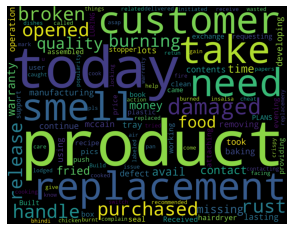

In [228]:
red_neg =' '.join([str(word) for word in features])
wordcloud_neg = WordCloud(
        background_color = 'black',
        width = 1800,
        height = 1400
        ).generate(red_neg)
plt.imshow(wordcloud_neg)
plt.axis('off');

Defective product - suggestions better quality standard check, packaging, built quality<br><br>

Product breakdown in first few usage<br><br>

Product design- plastic smell, handle, unlock mechanism, outer basket, inner container, uneven cooking, temperature, eject button, front pannel, rusting<br><br>

service - customer service, no user guide/manual instructions, warranty card <br><br>

Chinese product<br><br>

In [241]:
pattern = [
            {'POS': 'VERB'}, 
            {'POS':'ADP','OP':'?'},
            {'POS': 'NOUN'}
        ]

In [242]:
text = df[df['Final label']=='neg']['review'].str.cat(sep=', ')
doc = nlp(text)

In [243]:
found_matches = match(pattern,doc,'pattern')

In [244]:
features = []
for i,start,end in found_matches:
    features.append(doc[start:end])
len(features)

96

In [245]:
print(features)

[using mccain, manufacturing defect, overlooked as box, delivered on evening, took lots, lasting product, lead to unlocking, removing contents, baking tray, rust developing, continue operation, purchased hairdryer, opened seal, working evening, broken handle, Received replacement, made of plastic, sealed by tape, opened box, have rust, attaching pics, requesting exchange, LURING PLANS, given by people, release push, providing stopper, burning smell, properly;Issues with packaging, assembled price, Built quality, clean food, came today, need replacement, Returned for refund, go for phillips, burning plastic, looking at majority, missing user, recipe book, contact support, broken handle, contacting customer, lodged complain, missing papers, avail warrenty, wasted time, need replacement, need money, replaced asap, facing switch, related issue, fried chicken, get smell, receive warranty, take care, burned mark, contact insalsa, peeling off oyn, fried food, cooking pan/, damaged product, co

## Topic modelling

In [205]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

In [246]:
dtm = cv.fit_transform(neg_review['cleaned review'])
dtm

<137x867 sparse matrix of type '<class 'numpy.int64'>'
	with 1832 stored elements in Compressed Sparse Row format>

In [253]:
# Perform LDA
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=2,random_state=42) # No of components is number of topics you expect

In [255]:
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [256]:
# Grab highest probability words per topic
for i in range(len(lda.components_)):
    print(f'Top 20 words for Topic #{i} :') 
    single_topic = lda.components_[i]
    single_topic.argsort() # sorts the values from lowest to highest returning a list of indices, gives the index we must look for highest probability
    # top 10 words with highest probability values is given by 
    print([cv.get_feature_names()[index] for index in single_topic.argsort()[-20:]])
    print('\n\n')

Top 20 words for Topic #0 :
['dont', 'doesnt', 'work', 'use', 'box', 'warranty', 'defective', 'buy', 'stopped', 'inalsa', 'today', 'received', 'service', 'time', 'got', 'heating', 'damaged', 'customer', 'working', 'product']



Top 20 words for Topic #1 :
['inalsa', 'basket', 'return', 'amazon', 'poor', 'cooking', 'day', 'broken', 'air', 'time', 'food', 'got', 'bad', 'stopped', 'fryer', 'use', 'quality', 'handle', 'working', 'product']





In [ ]:
Topic #0 : customer service, defective product, stopped working/doesnt work
Topic #1 : handle, basket, quality, broken, issues with food, cooking time - design and built quality

In [257]:
topic_results = lda.transform(dtm)
neg_review['Topic']=topic_results.argmax(axis=1)
neg_review

<ipython-input-257-be4449f34853>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_review['Topic']=topic_results.argmax(axis=1)


,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review,summary,Topic
1,1.0,"Earlier I gave a positive review, but after us...",neg,0.7941,pos,neg,Earlier I gave a positive review but after usi...,positive review to take good things said about...,0
3,2.0,I bought this in the prime day sale on 15th Ju...,neg,-0.6808,neg,neg,I bought this in the prime day sale on th July...,prime day day sale brand value inalsa products...,0
4,1.0,Product has manufacturing defect as the right ...,neg,-0.8519,neg,neg,Product has manufacturing defect as the right ...,has manufacturing manufacturing defect right s...,0
7,1.0,An impulse purchase based on Inalsa Brand name...,neg,-0.2263,neg,neg,An impulse purchase based on Inalsa Brand name...,impulse purchase based on based on Inalsa deli...,1
9,1.0,Paint of the baking tray coming off. If its p...,neg,-0.1280,neg,neg,Paint of the baking tray coming off If its pa...,baking tray coming off healthThen rust rust de...,0
...,...,...,...,...,...,...,...,...,...
528,2.0,An average product with delicate plastic compo...,neg,0.2732,pos,neg,An average product with delicate plastic compo...,average product delicate plastic plastic compo...,0
534,3.0,Very low quality product plus the lock got dam...,pos,-0.4201,neg,neg,Very low quality product plus the lock got dam...,low quality quality product damaged in to pay ...,0
550,1.0,Stopped working only after a month. Very bad p...,neg,-0.4818,neg,neg,Stopped working only after a month Very bad pr...,Stopped working bad product nt buy,0
553,1.0,We expected good service but I salsa is very b...,neg,-0.6046,neg,neg,We expected good service but I salsa is very b...,good service bad customer take action insala p...,0


C:\Users\priya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Topic', ylabel='count'>

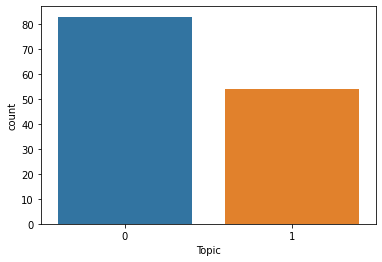

In [258]:
sns.countplot(neg_review['Topic'])

## Competitor products

In [2]:
Varada_data = pd.read_csv("Varada_reviews.csv")
American_data = pd.read_csv("Americanmicronic_reviews.csv")
philipsneg_data = pd.read_csv("bestsellerphillips_negreviews.csv")
philipspos_data = pd.read_csv("bestsellerphillips_posreviews.csv")


data = pd.concat([Varada_data,American_data, philipsneg_data,philipspos_data])
data = data.rename(columns = {'title': 'review_title', 'rating': 'rating', 'body': 'review','date':'date'}, inplace = False)
print(data.shape)
data.head()

(691, 4)


,review_title,rating,review,date
0,Great 4.5 L Air fryer. Works nice. Looks great!,4.0,First review : Got this a week back and so far...,3-Feb-21
1,An emerging brand that is gonna give a tough c...,5.0,The fryer feels premium and is working really ...,26-Mar-21
2,"Nice, easy to use , make the food real fast an...",4.0,It seems to be nice. It makes food really cris...,9-Feb-21
3,Varada's Great Air Fryer first time I am usin...,5.0,4.5 lit capacity Air fryer will fits the need ...,16-Mar-21
4,Elegant red air fryer..must buy,4.0,"Amazing product ,it's very user friendly and t...",27-Mar-21


In [3]:
df = data.copy().drop(columns=['date', 'review_title'])
print(len(df))
df.head()

691


,rating,review
0,4.0,First review : Got this a week back and so far...
1,5.0,The fryer feels premium and is working really ...
2,4.0,It seems to be nice. It makes food really cris...
3,5.0,4.5 lit capacity Air fryer will fits the need ...
4,4.0,"Amazing product ,it's very user friendly and t..."


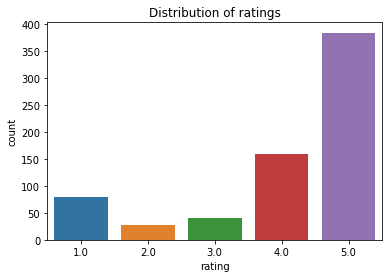

In [4]:
sns.countplot(data= df, x='rating')
plt.title('Distribution of ratings');

In [5]:
def labeling(rating):
    if rating >=3:
        return 'pos'
    else:
        return 'neg'

In [6]:
df['rating_label'] = df['rating'].apply(labeling)
df.head()

,rating,review,rating_label
0,4.0,First review : Got this a week back and so far...,pos
1,5.0,The fryer feels premium and is working really ...,pos
2,4.0,It seems to be nice. It makes food really cris...,pos
3,5.0,4.5 lit capacity Air fryer will fits the need ...,pos
4,4.0,"Amazing product ,it's very user friendly and t...",pos


In [7]:
sid = SentimentIntensityAnalyzer()

df['compound_score'] = df['review'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['compound'])
# = df['scores']
df['vader_label'] = df['compound_score'].apply(lambda c: 'pos' if c >= 0 else 'neg')
df.head()

,rating,review,rating_label,compound_score,vader_label
0,4.0,First review : Got this a week back and so far...,pos,0.8020,pos
1,5.0,The fryer feels premium and is working really ...,pos,0.9406,pos
2,4.0,It seems to be nice. It makes food really cris...,pos,0.3818,pos
3,5.0,4.5 lit capacity Air fryer will fits the need ...,pos,0.9774,pos
4,4.0,"Amazing product ,it's very user friendly and t...",pos,0.8801,pos


In [9]:
temp = df[df['vader_label']!=df['rating_label']]
print(f'Number of label mismatches: {len(temp)}')

Number of label mismatches: 87


In [10]:
temp.head(7)

,rating,review,rating_label,compound_score,vader_label
7,5.0,I used to go to gym so I had to eat chicken da...,pos,-0.2003,neg
1,1.0,"I purchased this in 2017, and have been using ...",neg,0.6655,pos
7,3.0,Air fryer is not bad. Well worth money? Kinda....,pos,-0.1910,neg
31,1.0,Better go buy a conventional oven it's better ...,neg,0.9417,pos
32,5.0,Used for 6 months now. Nice product. Not easy ...,pos,-0.5520,neg
36,1.0,Product not in working condition even power a...,neg,0.3724,pos
45,5.0,My wife using it for last three months with no...,pos,-0.2960,neg


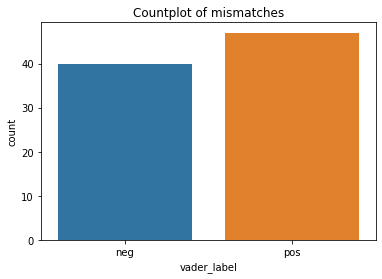

In [11]:
sns.countplot(data=temp, x= 'vader_label')
plt.title('Countplot of mismatches');

In [12]:
df['Final label'] = df['vader_label']
j = df.columns.get_loc('Final label')
for i in temp.index.values.tolist():
    df.iloc[i,j] = 'neg'
df.head()


,rating,review,rating_label,compound_score,vader_label,Final label
0,4.0,First review : Got this a week back and so far...,pos,0.8020,pos,pos
1,5.0,The fryer feels premium and is working really ...,pos,0.9406,pos,neg
2,4.0,It seems to be nice. It makes food really cris...,pos,0.3818,pos,neg
3,5.0,4.5 lit capacity Air fryer will fits the need ...,pos,0.9774,pos,pos
4,4.0,"Amazing product ,it's very user friendly and t...",pos,0.8801,pos,pos


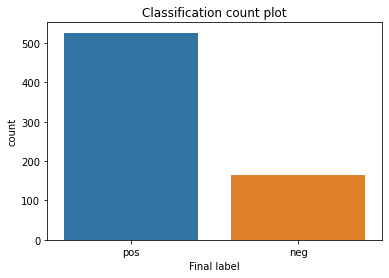

In [13]:
sns.countplot(data= df, x='Final label')
plt.title('Classification count plot');

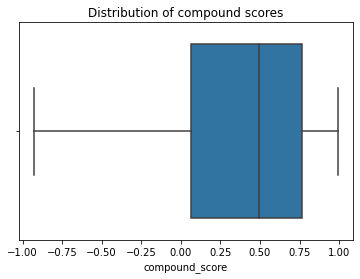

In [14]:
sns.boxplot(data=df,x='compound_score')
plt.title('Distribution of compound scores');
# 3 out 4 customers are happy with the product

In [15]:
df['Final label'].value_counts()/len(df)

pos    0.761216
neg    0.238784
Name: Final label, dtype: float64

In [50]:
pip install -U seaborn

Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


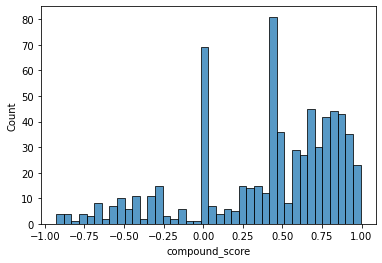

In [16]:
sns.histplot(data=df,x='compound_score',bins=40);
# Most positive people are extremely happy with the product
# Comparatively some are extremely disappointed

In [25]:
# Segregate positive and negative reviews using final labels 
# Plot wordcloud for each 
# Draw inferences w.r.t challenges and features

In [17]:
def display_wordcloud(text,bg_color):
    #for word in []:
    #    STOPWORDS.add(word)
    path_to_font = 'C:/Users/priya/Downloads/bon_foyage/BonFoyageDemo.otf'
    #path_to_image = 'C:/Users/priya/OneDrive/Desktop/NLP_Project/IMG.png'
    # mask = np.array(Image.open(path_to_image))
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(stopwords=STOPWORDS, font_path=path_to_font,
               #mask=mask,
               background_color=bg_color,
               max_words=50, max_font_size=256,
               random_state=42, width=1000,
               height=1000).generate(text)
    plt.imshow(wordcloud,interpolation="bilinear") # display image
    plt.axis("off"); #No axis details

In [18]:
def clean_text(review):
    # remove numbers
    review = re.sub('[\d]+','',review) 
    # remove emoticon
    review = review.encode('ascii', 'ignore').decode('ascii') 
    # remove punctuation
    return "".join([x for x in review if x not in string.punctuation])    

In [19]:
df['cleaned review'] = df['review'].apply(lambda x:clean_text(x))
df.head()

,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review
0,4.0,First review : Got this a week back and so far...,pos,0.8020,pos,pos,First review Got this a week back and so far ...
1,5.0,The fryer feels premium and is working really ...,pos,0.9406,pos,neg,The fryer feels premium and is working really ...
2,4.0,It seems to be nice. It makes food really cris...,pos,0.3818,pos,neg,It seems to be nice It makes food really crisp...
3,5.0,4.5 lit capacity Air fryer will fits the need ...,pos,0.9774,pos,pos,lit capacity Air fryer will fits the need of ...
4,4.0,"Amazing product ,it's very user friendly and t...",pos,0.8801,pos,pos,Amazing product its very user friendly and the...


In [20]:
pos_reviews = df[df['Final label']=='pos']['cleaned review'].str.cat(sep=', ')
pos_reviews = ''.join(pos_reviews)
display_wordcloud(pos_reviews,'white') # '#f5faf8'

OSError: cannot open resource

<Figure size 720x720 with 0 Axes>

In [ ]:
neg_reviews = df[df['Final label']=='neg']['cleaned review'].str.cat(sep=', ')
neg_reviews = ''.join(neg_reviews)
display_wordcloud(neg_reviews,'black') # '#fcf7f8'

### Competitor's positive reviews

In [21]:
pos_reviews = df[df['Final label']=='pos']
pos_reviews.head()

,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review
0,4.0,First review : Got this a week back and so far...,pos,0.8020,pos,pos,First review Got this a week back and so far ...
3,5.0,4.5 lit capacity Air fryer will fits the need ...,pos,0.9774,pos,pos,lit capacity Air fryer will fits the need of ...
4,4.0,"Amazing product ,it's very user friendly and t...",pos,0.8801,pos,pos,Amazing product its very user friendly and the...
5,4.0,Easy to use.Long tongs with silicone ends are ...,pos,0.7564,pos,pos,Easy to useLong tongs with silicone ends are v...
8,5.0,"The product is really good, easy to use, good ...",pos,0.8849,pos,pos,The product is really good easy to use good qu...


In [ ]:
# Perform analysis for positive reviews above

In [ ]:
# Related visualizations

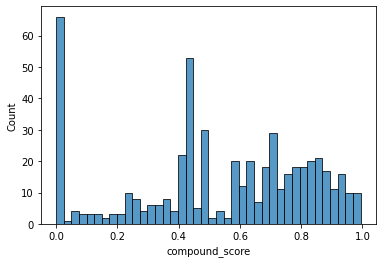

In [24]:
sns.histplot(data=pos_reviews,x='compound_score',bins=40);

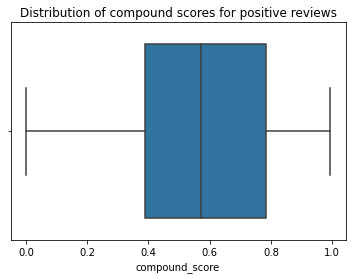

In [28]:
sns.boxplot(data=pos_reviews,x='compound_score')
plt.title('Distribution of compound scores for positive reviews');
# 3 out 4 customers are happy with the product

### Competitor's Negative reviews

In [30]:
neg_reviews = df[df['Final label']=='neg']
neg_reviews.head()

,rating,review,rating_label,compound_score,vader_label,Final label,cleaned review
1,5.0,The fryer feels premium and is working really ...,pos,0.9406,pos,neg,The fryer feels premium and is working really ...
2,4.0,It seems to be nice. It makes food really cris...,pos,0.3818,pos,neg,It seems to be nice It makes food really crisp...
6,5.0,This product is amazing and delivery was fast....,pos,0.9777,pos,neg,This product is amazing and delivery was fast ...
7,5.0,I used to go to gym so I had to eat chicken da...,pos,-0.2003,neg,neg,I used to go to gym so I had to eat chicken da...
9,5.0,Your browser does not support HTML5 video.\n\n...,pos,0.5487,pos,neg,Your browser does not support HTML video\n\n\n...


In [ ]:
# Perform analysis for negative reviews above

In [ ]:
# Related visualizations

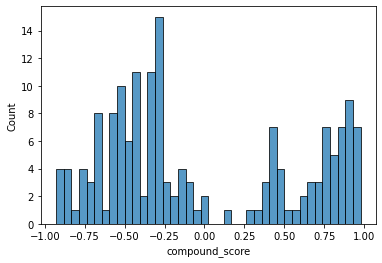

In [31]:
sns.histplot(data=neg_reviews,x='compound_score',bins=40);

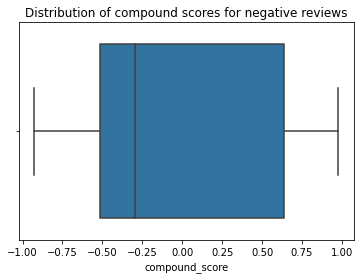

In [32]:
sns.boxplot(data=neg_reviews,x='compound_score')
plt.title('Distribution of compound scores for negative reviews');
# 3 out 4 customers are happy with the product

## Best seller product

In [ ]:
# Comparison using Bayesian statistical technique

In [33]:
philipsneg_data = pd.read_csv("bestsellerphillips_negreviews.csv")
philipspos_data = pd.read_csv("bestsellerphillips_posreviews.csv")